# Introduction to Data Science and Systems 2020-2021<small><small>v20202021b</small></small>
## Lab 4: Data Science in practice
#### - ***you should submit this notebook on Moodle along with one pdf file (see the end of the notebook and Moodle for instructions)***
---
#### University of Glasgow


$$
\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\expect}[1]{\mathbb{E}[#1]}
$$

## Purpose of this lab

In the lab you will apply some of the data science and systems techniques you have learned about previously. The aim is to use the basic techniques to solve a specific problem related to accessing and storing data in a Panda dataframe. 

#### Part 1:
* revisit how to use Pandas to easily load and inspect a dataset 

#### Part 2:
* implement a solution for compressing the values in the dataset based on PCA

####  Part 3:
* investigate the relationship between query cardinality and the query itself
* sample a set of realistic queries using your knowledge of probability density functions
* collect a dataset of queries and cardinality using Pandas 
* suggest and implement your own solution for predicting the cardinality of the query (using linear algebra)



***Notice:*** 
- This lab is more open-ended than the previous labs and there are fewer step-by-step instructions.
- It is a brand new lab so there are bound to be a few glitches, so don't hesitate to ask if you get stuck.


---

# Before you begin

Please update the tools we use for the automated grading by running the below command (uncomment) and restart your kernel (and then uncomment again) -- or simply perform the installation externally in an Anaconda/Python prompt.

In [1]:
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master

In [2]:
# Standard imports
# Make sure you run this cell!
from __future__ import print_function, division
import numpy as np  # NumPy
import scipy.stats 
import os
import pandas as pd
import sys
import timeit
import time
import binascii
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string
import jhwutils.image_audio as ia
import jhwutils.tick as tick

###
tick.reset_marks()

# special hash funciton
def case_crc(s, verbose=True):
    h_crc = binascii.crc32(bytes(s.lower(), 'ascii'))
    if verbose:
        print(h_crc)
    return h_crc

# this command generaties a unique key for your system/computer/account
uuid_simple = (("%s") % get_mac())
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (os.path,sys.path,sys.version,sys.version_info,get_mac())
uuid_system = case_crc(uuid_str,verbose=False) 


# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
np.random.seed(2019)

# You can ignore this
print("np",np.__version__)
print("pd",pd.__version__)
print("Everything imported OK (ignore deprecated warnings)")

np 1.20.0
pd 1.1.3
Everything imported OK (ignore deprecated warnings)


/Users/satoshi.liu/opt/anaconda3/lib/python3.8/site-packages/IPython/kernel/__init__.py:12: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  warn("The `IPython.kernel` package has been deprecated since IPython 4.0."


In [3]:
# Hidden cell for utils needed when grading (you can/should not edit this)

---

## Part 1 Loading and inspecting the data
The system admins are planning on storing the data in a Panda dataframe ("the database") insted of a more traditional database.
However, they are concerned about the performance of the Panda-based system and have decided to investigate further.

#### Part 1.1 Download the dataset
Download the Covertype Data Set from the UCI repository and save it in a subfolder called data (i.e. when loading you should load from "./data/covtype.data")

https://archive.ics.uci.edu/ml/datasets/Covertype

#### Part 1.2 Loading the dataset
Load the dataset in covtype.data into a Panda dataframe and add appropriate headers to the first 11 columns (at least) according to the dataset description (i.e. the first column should be "Elevation"). Hint: consider using the "rename" method.


In [5]:
data = pd.read_csv("./data/covtype.data", header=None) # DO NOT CHANGE THIS!

# YOUR CODE HERE
headers_ = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
           "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points",
           "Wilderness_Area[0]", "Wilderness_Area[1]", "Wilderness_Area[2]", "Wilderness_Area[3]"]
for i in range(14):
    data = data.rename(columns={i: headers_[i]})

In [6]:
# Check that you have (most likely) the right data set and have added headers.
with tick.marks(6):        
    assert(np.sum(data['Elevation'].to_numpy()) == 1719426752)    
    for i in range(0,11):
        assert(isinstance(data.columns[i],str))
        

#### Part 1.3 Basic stats
We can use Panda's `describe` function to extract some useful statistics

In [7]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,45,46,47,48,49,50,51,52,53,54
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


From the table above, identify the median and mean for the `Elevation` measurements and save the values in variables named `stats_mean_elevation` and `stats_median_elevation` (two decimals). 

***Hint***: You may need to do a bit of investigation into what the 'describe' function outputs.

In [8]:
# YOUR CODE HERE
stats_mean_elevation = data.describe()["Elevation"]["mean"]
stats_median_elevation = data.describe()["Elevation"]["50%"]

In [9]:
with tick.marks(4):    
    assert(check_hash(stats_mean_elevation, ((), 14796.849999999999)))
    

In [10]:
with tick.marks(4):    
    assert(check_hash(stats_median_elevation, ((), 14980.0)))
    

----

### Part 2 Dataset Compression 

#### Part 2.1
In an attempt to optimise the database the team is looking to use PCA to compress the dataset (i.e. reduce the number of bits we need to store).

It is speculated that the following measurements can be represented in a low dimensional space without too much loss of information.
>    - 'Elevation'
>    - 'Aspect'
>    - 'Slope'
>    - 'Horizontal_Distance_To_Hydrology'
>    - 'Vertical_Distance_To_Hydrology'
>    - 'Horizontal_Distance_To_Roadways'
>    - 'Hillshade_9am'
>    - 'Hillshade_Noon '
>    - 'Hillshade_3pm '
>    - 'Horizontal_Distance_To_Fire_Points '
>    - 'Wilderness_Area[0]'  (meaning only the first of the 4 Wilderness_Area columns)
 
1) Extract the relevant data in a separate numpy array (do not modify the dataframe itself). Demean and standardize the extracted data such that each column has zero mean and a standard deviation of one.

2) Compute the PCA (use np.linalg.eig) and determine the minimum number of components required to preserve 70% of variance. Save the number of components in `n_components` (i.e. an integer). The relative contribution from one principle component is measured as $\frac{\lambda_i}{\sum_{j=1}^J \lambda_j}$ where $\lambda$ is the eigenvalue for that component and $J$ is the number of eigenvalues.  

3) Provide the "compressed" version of the data in `data_lowd` with dimension (581012, n_components).


***Note:*** There are no visible tests in this part as we expect you will be able to solve this given the knowledge you have acquired in earlier labs.


In [11]:
# YOUR CODE HERE
# zero mean and a standard deviation of one
relevant = np.array(data)[:,:11]
mean_vector = relevant.mean(0)
demeaned_data = relevant - mean_vector
stded_data = np.std(relevant, axis=0)
demeaned_stded = demeaned_data / stded_data

# get covariance matrix of data
data_cov = np.cov(demeaned_stded, rowvar=False)

# get eigenvlaues and eigenvectors
data_pc_len, data_pc = np.linalg.eig(data_cov)
order = np.argsort(-np.abs(data_pc_len))
data_pc_len = np.sqrt(data_pc_len[order])
data_pc = data_pc[:, order]

In [12]:
# calculate minimum number of components
va_sum = 0
n_components = 0
for i in range(len(data_pc_len)):
    weight_ = data_pc_len[i] / np.sum(data_pc_len)
    va_sum += weight_
    print("PC", i+1, "weighs", weight_, "and overall weight till now is", va_sum)
    if va_sum >= 0.7:
        n_components = i+1
        break
        
print("=================================================")
print("The minimum number of components is", n_components)

PC 1 weighs 0.16470042592772055 and overall weight till now is 0.16470042592772055
PC 2 weighs 0.15764918944024334 and overall weight till now is 0.3223496153679639
PC 3 weighs 0.13409258937972543 and overall weight till now is 0.4564422047476894
PC 4 weighs 0.113805534963712 and overall weight till now is 0.5702477397114014
PC 5 weighs 0.08927820570363319 and overall weight till now is 0.6595259454150346
PC 6 weighs 0.07993003603895714 and overall weight till now is 0.7394559814539917
The minimum number of components is 6


In [13]:
# get low-dimensional version of relevant data
data_lowd = np.dot(relevant, data_pc[:,0:n_components])

In [14]:
### Hidden test checking n_components [6 marks]


In [15]:
### Hidden test test checking data_lowd of shape (581012, n_components) [15 marks]

---

## Part 3: Cardinality of the result set

#### Part 3.1 Queries
The database team is interested in optimising the performance of the system when querying the dataframe. To test the performance, queries are assumed to relate only to the Elevation column and are specified as an interval. For example, a query [2500,2061] would return all entries where the Elevation is between 2500 and 2061.

The actual query which is executed by the Panda is then specified as $[a,b]$ or $[c-s/2, c+s/2]$. A couple of probability density functions have been formulated and believed to generate a set of realistic queries. 

The $c$ value, or the center of the interval, is sampled according to the following probability density function:

$$p(c) = 0.3\cdot Normal(\,c\,|\,2500,50) + 0.4\cdot Normal(\,c\,|\,3000,100) + 0.3\cdot Normal(\,c\,|\,3250,80)\,\,\,\,\,\,\,\,\, (Eq. 1)$$  

Thus $p(c)$ is made up of three so-called components with each component being a Normal distribution parameterised by the mean and standard deviation.

The $s$ (the size of the interval) is sampled according to the following probability density function:

$$p(s) = Gamma(s|8,25)\,\,\,\,\,\,\,\,\,  (Eq. 2)$$

where the parameters are the shape and scale, respectively. Gamma is a special probability distribution which you should lookup.

***Note:*** There is not a specific question here - you just have to examine the equations and the various distributions.


#### Part 3.2 Sample a set of queries
You must now complete a function which can sample 2000 queries from the query distribution defined by Eq. (1) and Eq. (2).

Save the queries $[c,s]$ as rows in `X` (i.e. `X` should be of size (2000,2) ).

***Hint***: You are looking to sample from these distribution; not compute the density (i.e. you should not implement the equations per se). For $p(c)$, first sample a component with the given probability, then sample from that component. 


In [16]:
def sample_queries(N=2000):    
        
    # YOUR CODE HERE
    X = []
    mean = [2500, 3000, 3250]
    std = [50, 100, 80]
    for i in range(N):
        s = np.random.gamma(8, 25, 1)
        n = np.random.choice(3, p=[0.3, 0.4, 0.3])
        X.append([np.random.normal(mean[n], std[n], 1)[0], s[0]])
    X = np.array(X)
    return X


Let's sample...

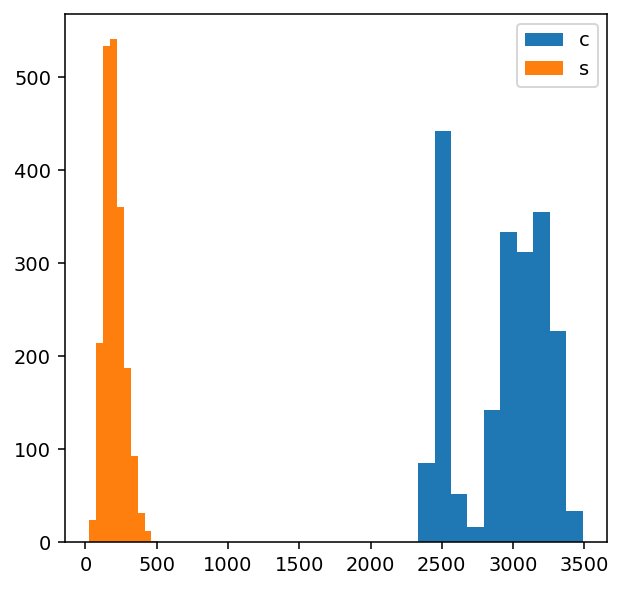

In [17]:
np.random.seed(1111) # you may want to provide a seed to consistent results
X = sample_queries(N=2000)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.hist(X[:,0])
ax.hist(X[:,1])
ax.legend(('c','s'))


In [18]:
# Note this test only ensure that you you have sensible sampler
# - it is not absolute evidence 
# that your sampler is exactly as specified (you should make 
# extra sure to test your implementation)
#
# You sampler will be checked manually when marking against a more 
# extentive test and you marks are thus tentative!
#

with tick.marks(10):        
    query_function_is_likely_correct = False
    for irep in range(0,3): # repeat a few times to make it wasn't a lucky run
        for n in [100000]:
            samples = sample_queries(n)
            assert samples.shape == (n,2)
            assert np.min(samples[:,0]) > 0
            assert np.min(samples[:,1]) > 0            
            qc  = np.quantile(samples[:,0], np.linspace(0.1,0.95,10))
            qs  = np.quantile(samples[:,1], np.linspace(0.1,0.95,10))                                                    
            qc_true = np.array([2478.04573054, 2518.19126684, 2588.47755615, 2917.62945017,
            2984.9975373 , 3045.53633682, 3117.29174297, 3193.0221899,
            3255.41404674, 3327.7111032])            
            qs_true =  np.array([116.55924418, 138.49041163, 155.92921611, 171.96901016,
            187.79187985, 204.68888341, 223.16652347, 245.08779129,
            275.02758806, 328.7319762])            
            assert( np.all( np.abs(qc_true - qc) < 25 ))
            assert( np.all( np.abs(qs_true - qs) < 10 ))                
    
    query_function_is_likely_correct = True
    

In [19]:
# A placeholder for the automarker

#### Part 3.3 Execute a single query 
You must now complete a function which can execute a single query based on the start and end points of the interval, [a,b], against the database (in this case a Panda dataframe stored in the variable named ´data´)

The function must return:
- the time taken in seconds (already provided), t
- the cardinality of the result set, n
- the result set, i.e. all rows where $a=c-s/2 \leq Elevation \leq b=c+s/2$

***Hint***: You may need to consult the documentation for Panda to find a suitable command.

In [20]:
def query(a,b):    
    tic=timeit.default_timer()    
    
    # YOUR CODE HERE
    res = data.query('@a <= Elevation <= @b')
    n = len(res)
    
    toc=timeit.default_timer() 
    t = toc - tic 
    return t, n, res          

In [21]:
with tick.marks(5): 
    query_function_is_correct = False
    t, n, res = query(2967.0,2967.5)
    z = np.sum(res['Aspect'].to_numpy())    
    assert( n == 762 )
    assert( z == 121183 )
    query_function_is_correct = True
    

#### Part 3.4 Execute and time all queries

You should now execute all the queries in `X` against the database by calling the function `query`. Queries should be read from the `X` array previously generated.

The resulting data should be collected in two numpy arrays:

- `y_times` with shape (2.000,1) holding the times measured for each query
- `y_cardinality` with shape (2.000,1) holding the size of the result set for each query


In [22]:
N = np.shape(X)[0]
y_times = np.zeros((N,1))
y_cardinality = np.zeros((N,1))

# Hint remember that you need to parse a and b to query (not c and s)
# YOUR CODE HERE
for i in range(len(X)):
    c = X[i][0]
    s = X[i][1]
    y_times[i], y_cardinality[i], X_tmp = query(c-s/2, c+s/2)

In [23]:
# Hidden test (make sure you test your function carefully!) [5 marks]


We can then plot the distribution of the cardinality measurements... Validate that the histogram looks like you expect.


Text(0.5, 1.0, 'Orginal')

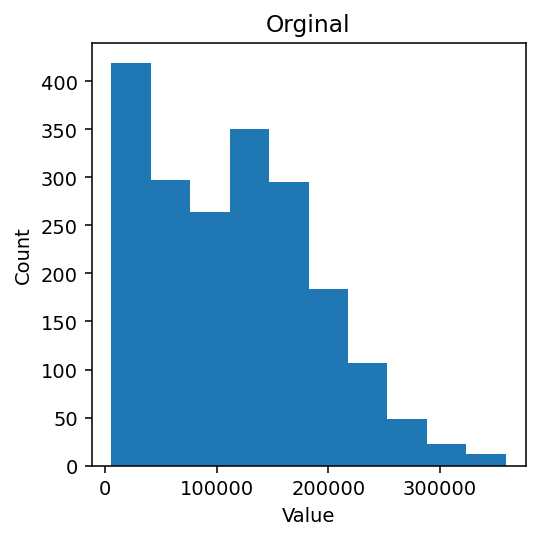

In [24]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot(1,1,1) 
ax.hist(y_cardinality)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Orginal')

#### Part 3.5 Save the data for later use (and for testing/validation )

In [25]:
np.savez('datalog.npz', X=X,y_times=y_times,y_cardinality=y_cardinality)

---

#### Part 3.6 Map from query to cardinality
We are now interested in specifying a function which can map from a query (i.e. x=[c,s]) to the query cardinality for this database (i.e the Panda dataframe).

The function is pre-defined as:: 

$$f(x;\theta ) = {w_0} + {w_1}c + {w_2}s + {w_3}{c^2} + {w_4}{s^2} + {w_5}{c^3} + {w_6}{s^3} + {w_7}{c^4} + {w_8}{s^4} + {w_9}\cdot c \cdot s \,\,\,\,\,\,\,\, (Eq. 3)$$

where x is a query which is mapped through f to the query cardinality. The loss defined as 

$$L\left( \theta  \right) = \frac{1}{N} \sum\limits_{n = 1}^{N=2000} {{{\left( { {y_n} - f({x_n};\theta )} \right)}^2}} $$

You should now complete four classes/methods that the database team use in their estimation:

- `output_process` 
- `input_process`
- `predict`
- `estimate`
- `evaluate`

**Hint**: It is recommend that you write the function in matrix form (use pen and paper) before attempting to implement it.

Any method you implement must be based on pure Python and numpy (i.e. **you cannot use scikit learn or similar tools**).


**Marking:** The overall marking is based on whether you manage to a) beat a baseline prediction, and b) come close to the correct solution. There are intermediate marks to help you along.



In [26]:
# Load the generated data from the file
# This makes it easier to mark and debug your solution at marking time
# Hint: If you struggle to generate meaningful data in the previous part you can 
# copy the content of the cell to a new cell and load the file called datalog_demo.npz 
# which contains pre-generated observations.

tmp = np.load('datalog.npz')
X = tmp['X']
y_cardinality = tmp['y_cardinality']

In [27]:
# A placeholder for the automarker

In [28]:
y_cardinality = y_cardinality.reshape(2000,)
y_times = y_times.reshape(2000,)

#### Part 3.7 Input and output processing
Complete the `input_process` class for preprocessing the inputs, X (e.g. normalisaiton and other transforms of X). 

- `output_process`: is already provided and you shouldn't need to modify it. 
- `input_process`: you probably need to inspect the other functions and cells below (e.g. predict) to work out what to put here.


In [29]:
class output_process:    
    """
    A simple helper class which containes two functions for removing the mean of y and 
    adding it at prediction time 
    
    Requirement: y = rescale(scale(y))    
                        
    
    """
    y_mean = None # these are just proposals, you can modify the variables function as you se fit depending on if and how you wish to 
    y_std = None
    
    def __init__(self, y):                
        self.y_mean = 0 # this is a trick, it is only 0 for now
        self.y_mean = np.mean(self.scale(y),axis=0)        
        
    def scale(self,y):        
        """
        A function which scales/tranforms the y values, e.g. subtracting the mean.
        """       
        y_prime = y - self.y_mean                
        return y_prime
    
    def rescale(self,y_prime):
        """
        A function which re-scales/tranforms the y_prime value back to the orginal domain (e.g. undoes the effect of scale)
        E.g., adding a constant such as the mean.
        
        """        
        y = y_prime + self.y_mean         
        y[y<0]=0  # avoid negative predictions          
        return y         
    

In [30]:
class input_process:   
    """    
    A simple class which contains two functions for processing the 2D observation of the query x=(c,s) 
    and returns a potentailly scaled, normalised and expanded representation.                         
    """
    X_mean = None # proposal; the usage depends on you decicion to normalise X or not    
    X_std  = None # proposal; the usage depends on you decicion to standardise X or not    
        
    def __init__(self, X):         
        self.X_mean = 0 # this is a trick, it is only 0 for now
        self.X_std  = 1 # this is a trick, it is only 1 for now
        self.X_mean = np.mean(self.process(X)[:,1:] ,axis=0)                
        self.X_std  = np.std(self.process(X)[:,1:] ,axis=0)                
                    
    def process(self,X):
        """
        A function which takes the 2D in and processes the data, e.g. make a basis expansion and 
        standardise the result.
        
        """
        # YOUR CODE HERE
        # basis expansion
        tmp = np.zeros((len(X), 10))
        for i in range(len(tmp)):
            tmp[i][0] = 1
            tmp[i][1] = X[i][0]
            tmp[i][2] = X[i][1]
            tmp[i][3] = X[i][0]**2
            tmp[i][4] = X[i][1]**2
            tmp[i][5] = X[i][0]**3
            tmp[i][6] = X[i][1]**3
            tmp[i][7] = X[i][0]**4
            tmp[i][8] = X[i][1]**4
            tmp[i][9] = X[i][0]*X[i][1]
        
        # standardisation
        mean = tmp.mean(0)
        demeaned_data = tmp - mean
        std = np.std(tmp, axis=0)
        X = demeaned_data / std
        X[:,0:1] = 1
        
        return X

##### Input process:

We can apply the input process to query and observe the effect. This is the tricky bit so make sure to validate that input_process works as intended (there are no automated test to check this!).

**Note**: If you have done this the recommend/intended way, the output would not be 2D for each observations but rather 10D.

In [31]:
inprocess = input_process(X)
x_demo = inprocess.process(X[0:3,:]) # take 3 queries and see what happens to them
print(x_demo)

[[ 1.         -0.71482883 -1.35470489 -0.713828   -1.31468684 -0.71292405
  -1.26296344 -0.71211391 -1.20342305 -1.18767298]
 [ 1.          1.41418535  1.02889332  1.4141922   1.10867355  1.41419757
   1.18256476  1.41420172  1.24500751  1.25872345]
 [ 1.         -0.69935652  0.32581157 -0.7003642   0.20601329 -0.70127351
   0.08039867 -0.70208781 -0.04158446 -0.07105048]]


<ipython-input-30-242603a68728>:40: RuntimeWarning: invalid value encountered in true_divide
  X = demeaned_data / std


#### Part 3.8 Predict 
Implement a function that can predict the cardinality, $y$, of a query $x=[c,s]$ based on Eq. (3). The parameters are stored in `theta` (i.e. $w \in \mathbb{R}^{10}$), using only linear algebra/vector operations and calls to the relevant input and output process functions (these are shown). 

The function should return the estimate of the cardinality in $y$, and the scale prediction in y_prime. It must be able to make predictions for multiple observations in `X` (i.e. `X` is a matrix).

In [32]:
def predict(X, theta, output_process, input_process):      
    if input_process is not None: # note we use None when testing/marking
        X = input_process.process(X)
    
    # Hint: Only a single line of code is missing
    # YOUR CODE HERE
    y_prime = np.sum(X * theta.T, axis=1)
    
    if output_process is not None: # note we use None when testing/marking
        y = output_process.rescale(y_prime)
    else:
        y = y_prime
        
    return y, y_prime

In [33]:
# Hidden test validating the predict function [5 Marks]
# Test which test the core functionality of the predict function (it dones't test the input and output process)

with tick.marks(5):
    X_test = np.array([[1.2,8.54],[2.4,4.5]])
    theta = np.array([0.50722768, -1.32649421])
    y_test, y_prime_test = predict(X_test, theta, None, None)
        
    assert(check_hash(y_test, ((2,), -48.182417152)))
    assert(check_hash(y_prime_test, ((2,), -48.182417152)))    
    

#### Part 3.9
Write a function which computes the mean squared error (mse) based on the difference between the predicted and true query cardinality. It should also return the mean absolute error and the relative absolute error (in percent) wrt to the actual observation for the absolute error (i.e. how many percent is the prediction wrong on average).




In [34]:
def evaluate(y_pred,y_true):
    # YOUR CODE HERE
    error_mse = np.mean((y_pred - y_true)**2)
    error_abs = np.mean(np.abs(y_pred - y_true))
    error_abs_relative = np.mean((np.abs(y_pred - y_true) / y_true) * 100)
    return error_mse, error_abs, error_abs_relative

In [35]:
# Test checkign the evaluate function
with tick.marks(5):
    a,b,c = evaluate(np.array([4.5,6.2,-100.10]), np.array([14.5,-26.2,-110.10]))    
    assert(check_hash(a, ((), 2082.9333333333334)))
    assert(check_hash(b, ((), 87.33333333333333)))
    assert(check_hash(c, ((), -106.30209505074754)))      

#### Part 3.10
Implement a function which estimates the parameters, i.e., the $w$'s stored in `theta`, of the function based on the squared error loss defined above.

Hint: This should be done using only matrix operations and calls to the input/output process functions. You don't need numerical optimisation for this.


In [36]:
def estimate(X, y, outprocess, inprocess):
    """
    X: 2D queries/observations 
    y: observed cardinality (the orginal ones, i.e. not scaled or normalised) 
    outprocess: an instance of the output process class which is used to scale and rescale y
    inprocess: an instance of the input process class which is used to process the 2D input in X in a sensible way
    """        
    if outprocess is not None: # note we use None when testing/marking
        y = outprocess.scale(y)
        
    if inprocess is not None: # note we use None when testing/marking
        X = inprocess.process(X)
    
    # Hint: 2-3 lines of code missing
    # YOUR CODE HERE
    theta = np.linalg.pinv(X) @ y
    
    return theta

In [37]:
# Hidden test validating the estimate function[5 MARKS]
with tick.marks(7):
    X_test = np.array([[1.2,8.54,9.77],[2.4,4.5,-33.2]])
    y_yest = np.array([1,2])    
    theta_test = estimate(X_test, y_yest, None, None)
    assert(check_hash(theta_test, ((3,), 0.5095082848719855)))


#### Part 3.11

We can now put it all together and check if we are able to make sensible fit to the data.

Note: It might be necessary to revisit your implementation above in case you do not get a sensible fit in the first attempt.


In [38]:
inprocess = input_process(X)
outprocess = output_process(y_cardinality)
theta = estimate(X,y_cardinality,outprocess,inprocess)
y_pred, y_prime_pred = predict(X, theta, outprocess,inprocess)
error_mse, error_abs, error_abs_rel = evaluate(y_pred,y_cardinality)

print("The mse error is: ", error_mse)
print("The abs error is: ", error_abs)
print("The releative abs error is [pct]: ", error_abs_rel)

The mse error is:  183897978.56362036
The abs error is:  10072.602542533308
The releative abs error is [pct]:  14.29996433494249


<ipython-input-30-242603a68728>:40: RuntimeWarning: invalid value encountered in true_divide
  X = demeaned_data / std


#### Part 3.12

To evaluate the quality of your fit it is often useful to produce visualisation to aid our analysis. For this purpose you should now:

- Create a plot of the cardinality vs the ones estimated by the model. Include a line to illustrate the ideal prediction.
- Create a figure showing the distribution of errors
- Create a figure visualising the squared error against the the query cardinality 


Note: These are not assessed per se but suggested for your benefit. They will be written to the pdf file and inspected manually.

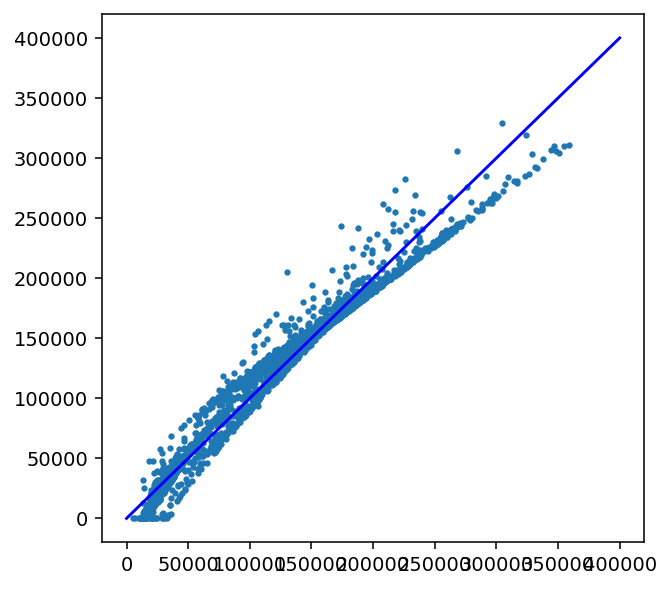

In [39]:
fig_312a = plt.figure(figsize=(5,5)) # DO NOT CHANGE
ax_312a = fig_312a.add_subplot() # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# YOUR CODE HERE
x = range(400000)
y = x
plt.scatter(y_cardinality, y_pred, s=5)
plt.plot(x, y, 'b-')

14.29996433494249


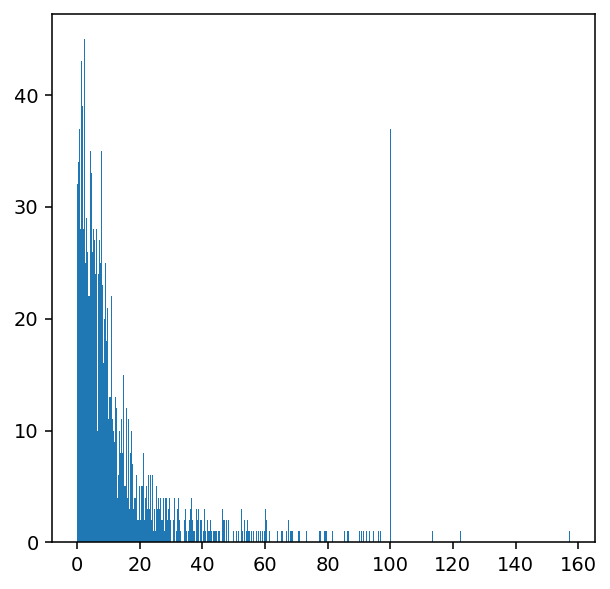

In [40]:
fig_312b = plt.figure(figsize=(5,5)) # DO NOT CHANGE
ax_312b = fig_312b.add_subplot(1,1,1) # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# YOUR CODE HERE
y_distribution = (np.abs(y_pred - y_cardinality) / y_cardinality) * 100
ax_312b.hist(y_distribution, bins=700)
print(y_distribution.mean())

273.8563150676987


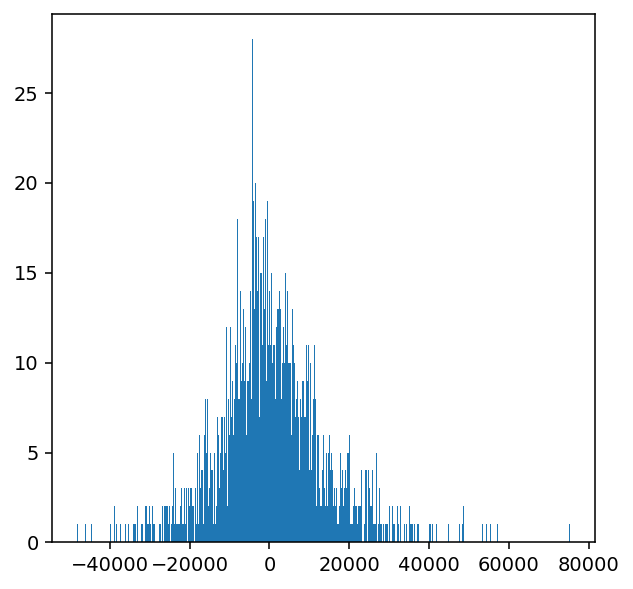

In [51]:
fig_312c = plt.figure(figsize=(5,5)) # DO NOT CHANGE
ax_312c = fig_312c.add_subplot(1,1,1) # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################

# YOUR CODE HERE
y_error = y_pred - y_cardinality
ax_312c.hist(y_error, bins=700)
print(y_error.mean())

#### Part 3.13 Baselines
To determine if your model is worth deploying and using for estimating the database load, your database team has requested you compare your function/fit to a naiive baseline.


The two baseline are:
- a) use the mean of the observation as the prediction for all queries 
- b) use the median of the observation as the prediction for all queries.   

Complete the `predict_average` and `predict_median` function below and compare with your predictive model.


In [42]:
def predict_average(y):    
    # YOUR CODE HERE
    y_avg = np.mean(y)
    return y_avg

In [43]:
def predict_median(y):    
    # YOUR CODE HERE
    y_med = np.median(y)
    return y_med

In [44]:
# Check that the baselines work as expected
with tick.marks(4):
    baseline_is_corrrect= False
    y_test = np.array([-3.4, 3, 6.2, 10])
    y_test_avg = predict_average(y_test)    
    y_test_median = predict_median(y_test)
    assert(check_hash(y_test_avg, ((), 19.75)))
    assert(check_hash(y_test_median, ((), 23.0)))
    baseline_is_corrrect = True
    

In [45]:
# Evaluate the baselines

y_pred_bl = predict_average(y_cardinality)
error_mse_bl, error_abs_bl, error_abs_rel_bl = evaluate(y_pred_bl,y_cardinality)
print("The mse error is: ", error_mse_bl)
print("The abs error is: ", error_abs_bl)
print("The relative abs error is [pct]: ", error_abs_rel_bl)

y_pred_blmed = predict_median(y_cardinality)
error_mse_bl, error_abs_bl, error_abs_rel_bl = evaluate(y_pred_blmed,y_cardinality)
print("The mse error is: ", error_mse_bl)
print("The abs error is: ", error_abs_bl)
print("The relative abs error is [pct]: ", error_abs_rel_bl)


The mse error is:  5255844839.246431
The abs error is:  60389.899523
The relative abs error is [pct]:  112.64341631860914
The mse error is:  5260700634.913
The abs error is:  60356.859
The relative abs error is [pct]:  110.47190666608078


Overall marking of your function...

In [46]:
# Hidden test, you get 5 marks for beating the median baseline (the baseline needs to be correct for any marks)

In [47]:
## Hidden test, you'll get 18 marks for obtaining a competetive performance close to our implementation 
# You'd need munually validation that you have obtained is a sensible and competetive solution.
